# Stochastische Prozesse

## Vertiefung

### Übersicht

1. Monte-Carlo-Simulation
2. Simulated Annealing

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter


### 1. Monte-Carlo-Simulation

Monte-Carlo-Simulation ist eine grosse Klasse von Methoden, die Fragestellungen mithilfe einer grossen Anzahl Zufallsexperimenten beantworten.

Beispiele:

- Bestimmen von statistische Eigenschaften von Zufallsprozessen, z.B. [Markow-Chain-Monte-Carlo-Verfahren (MCMC)](https://de.wikipedia.org/wiki/MCMC-Verfahren).
- Stochastisches Sampling der Zielfunktion eines Optimierungsproblems, siehe Simulated Annealing unten.
- Resampling von Daten, um statistische Eigenschaften zu bestimmen, z.B. [Bootstrapping](https://de.wikipedia.org/wiki/Bootstrapping-Verfahren).

#### Beispiel aus Einarbeitung: Diffusionsprozess

- Stationäre Verteilung
- Genauigkeit der Schätzung der stationären Verteilung

In [55]:
A, B = 0, 1
p_AB = 0.1
p_BA = 0.2


def markov_next(x, rng):
    if x == A:
        return rng.choice((A, B), p=(1 - p_AB, p_AB))
    else:
        return rng.choice((A, B), p=(p_BA, 1 - p_BA))


def markov_process(x, rng, n):
    xs = [x]
    for _ in range(n):
        x = markov_next(x, rng)
        xs.append(x)
    return np.array(xs)


Nehmen wir mal eine Population von `n_particles` Teilchen zufällig im Zustand A oder B. Dann simulieren wir deren Verläufe über `n_steps` Schritte und zeichnen nur den Endzustand auf. Wie ist der Endzustand über die ganze Population verteilt?

In [56]:
n_steps = 1000
n_particles = 250
rng = np.random.default_rng(987234)

ini_states = rng.choice((A, B), size=n_particles)
end_states = [markov_process(x, rng, n_steps)[-1] for x in ini_states]


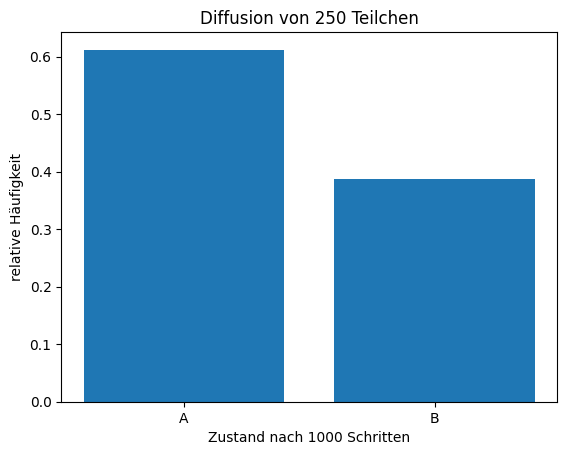

In [57]:
frequencies = np.bincount(end_states) / n_particles
plt.bar(["A", "B"], frequencies)
plt.xlabel(f"Zustand nach {n_steps} Schritten")
plt.ylabel("relative Häufigkeit")
plt.title(f"Diffusion von {n_particles} Teilchen")
plt.show()


Wir können aber auch alle Verläufe aufzeichnen und zu jedem Zeitpunkt die Verteilung der Zustände bestimmen.

In [58]:
n_steps = 1000
n_particles = 250
rng = np.random.default_rng(987234)

ini_states = rng.choice((A, B), size=n_particles)
# ini_states = np.full(n_particles, A)
walks = np.array([markov_process(x, rng, n_steps) for x in ini_states])

walks.shape


(250, 1001)

Jede Zeile ist eine Trajektorie. Jede Spalte entspricht den Zuständen ($A=0$ oder $B=1$) der Teilchen. Die Summe einer Spalte ist also die Anzahl Teilchen im Zustand $B=1$ zu diesem Zeitpunkt.

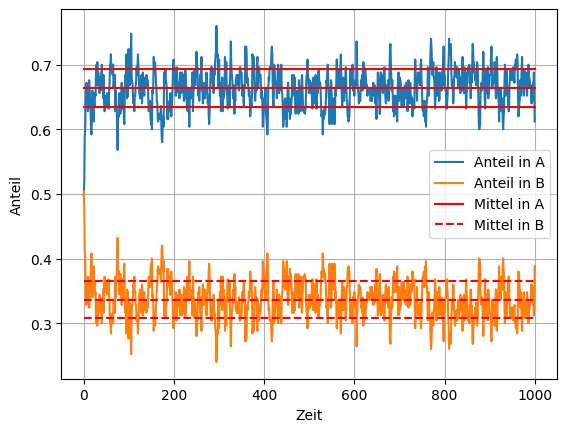

In [59]:
frac_B = np.sum(walks, axis=0) / n_particles
frac_A = 1 - frac_B
mean_frac_A = frac_A.mean()
mean_frac_B = frac_B.mean()
std_frac_A = frac_A.std()
std_frac_B = frac_B.std()

plt.plot(frac_A, label="Anteil in A")
plt.plot(frac_B, label="Anteil in B")
plt.plot(np.full_like(frac_A, mean_frac_A), "r", label="Mittel in A")
plt.plot(np.full_like(frac_B, mean_frac_B), "r--", label="Mittel in B")
plt.plot(np.full_like(frac_A, mean_frac_A + std_frac_A), "r")
plt.plot(np.full_like(frac_A, mean_frac_A - std_frac_A), "r")
plt.plot(np.full_like(frac_B, mean_frac_B + std_frac_B), "r--")
plt.plot(np.full_like(frac_B, mean_frac_B - std_frac_B), "r--")
plt.xlabel("Zeit")
plt.ylabel("Anteil")
plt.legend()
plt.grid()
plt.show()


#### Beispiel mit 3 Zuständen

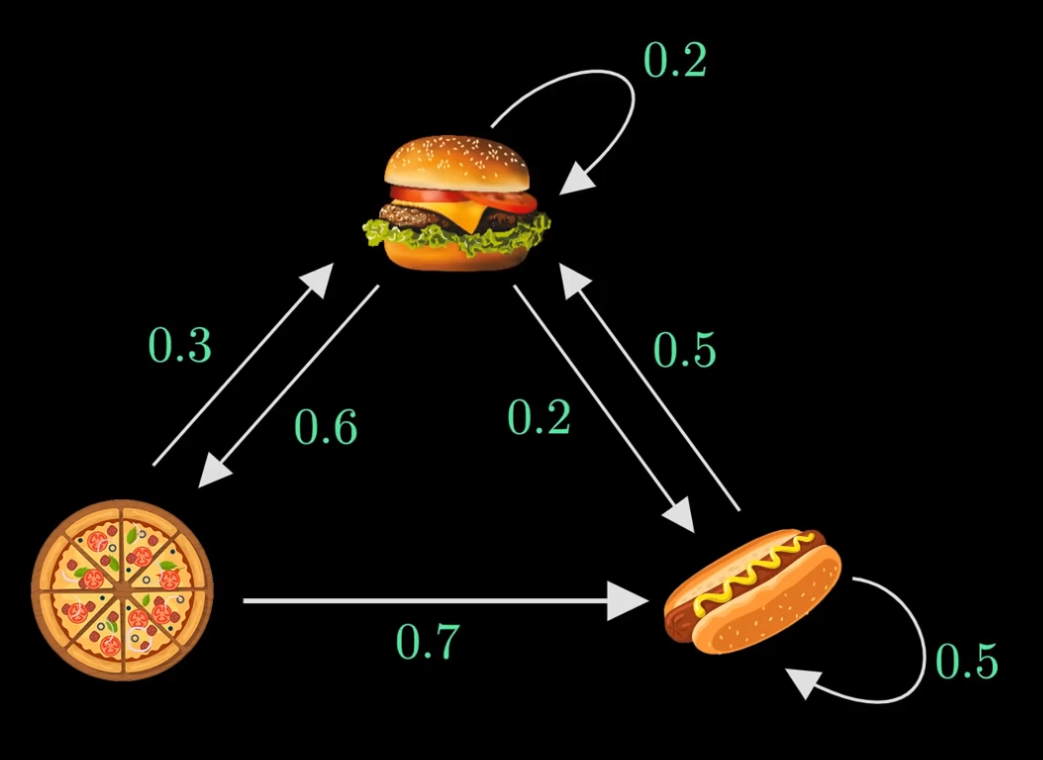

- ["Markov Chains Clearly Explained! Part - 1" - Normalized Nerd](https://www.youtube.com/watch?v=i3AkTO9HLXo&list=PLM8wYQRetTxBkdvBtz-gw8b9lcVkdXQKV)

In [60]:
HAMBURGER, PIZZA, HOTDOG = 0, 1, 2
states = (HAMBURGER, PIZZA, HOTDOG)
transition_matrix = (
    (0.2, 0.6, 0.2),
    (0.3, 0.0, 0.7),
    (0.5, 0.0, 0.5),
)


def markov_next(x, rng):
    return rng.choice(states, p=transition_matrix[x])


def markov_process(rng, n, x0=None):
    x = x0 if x0 is not None else rng.choice(states)
    xs = [x]
    for _ in range(n):
        x = markov_next(x, rng)
        xs.append(x)
    return np.array(xs)


n = 1000
rng = np.random.default_rng(982374)
xs = markov_process(rng, n)
np.bincount(xs) / len(xs)


array([0.34765235, 0.20779221, 0.44455544])

Nun bestimmen wir die Wahrscheinlichkeit, dass sich ein Walk nach $t$ Schritten in einem der Zustände befindet. Dazu führen wir eine Monte-Carlo-Simulation durch, indem wir 500 Walks simulieren.

In [61]:
n_steps = 1000
n_walks = 500
rng = np.random.default_rng(982374)
walks = np.array([markov_process(rng, n_steps) for _ in range(n_walks)])
walks.shape


(500, 1001)

Dann zählen wir die Häufigkeit der Zustände pro Zeitschritt (Spalte).

In [62]:
counts = np.array([np.bincount(col) for col in walks.T])
frequencies = counts / n_walks
frequencies.shape


(1001, 3)

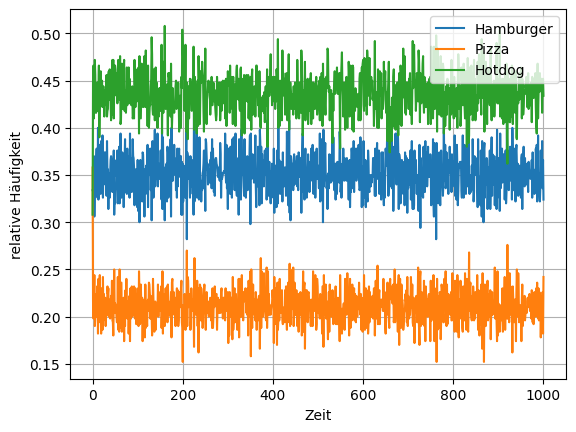

In [63]:
plt.plot(frequencies, label=("Hamburger", "Pizza", "Hotdog"))
plt.xlabel("Zeit")
plt.ylabel("relative Häufigkeit")
plt.legend()
plt.grid()
plt.show()


### 3. Simulated Annealing

[Simulated Annealing](https://de.wikipedia.org/wiki/Simulated_Annealing) ist ein stochastisches Optimierungsverfahren, das auf verschiedenste Probleme angewendet werden kann. Stochastisch bedeutet hier, dass bei der Suche des Optimums Zufallszahlen verwendet werden, um den Lösungsraum $D$ zu durchsuchen. Als eine Konsequenz kann man nicht sicher sein, ob man je das globale Optimum wirklich findet. Solche Verfahren werden dann genutzt, wenn exakte Methoden nicht anwendbar sind, weil der Lösungsraum zu gross ist oder die Zielfunktion zu komplex oder nicht differenzierbar ist.

Das gesuchte Optimum kann ein globales Minimum oder Maximum einer (skalaren) Zielfunktion $f$ sein. Hier formulieren wir es als ein Minimierungsproblem, ansonsten könnten wir einfach das Minimum von $-f(x)$ suchen.

$$
\text{Suche}\qquad
x_\text{opt} = \argmin_{x \in D} f(x)
\qquad \text{für} \qquad
f: D \rightarrow \mathbb{R}
$$

Der Lösungsraum $D$ kann eine Teilmenge des Vektorraums $\mathbb{R}^n$ sein, aber auch eine Menge von diskreten Werten. Die Funktion $f$ muss nicht stetig oder differenzierbar sein. Falls ein Maximum einer Funktion $g(x)$ gesucht würde, können wir einfach $f(x) = -g(x)$ minimieren.

Vorgehen:
1. Startpunkt $x_i \in D$ für $i=0$ wählen, evtl. zufällig.
2. Neuen Punkt $x_\ast$ zufällig aus der Umgebung von $x_i$ ziehen.
3. Falls $f(x_\ast) < f(x_i)$, dann $x_\ast$ als neuen Punkt wählen, also $x_{i+1}=x_\ast$. Sonst mit Wahrscheinlichkeit $p$ als neuen Punkt wählen, oder verwerfen.
4. Falls Abbruchkriterium erfüllt, dann $x_i$ als Lösung zurückgeben, sonst mit $i=i+1$ zu 2.

Die Akzeptanzwahrscheinlichkeit $p$ wird häufig als Boltzmann-Verteilung gewählt:

$$ p = \exp\left(-\frac{f(x_\ast)-f(x_i)}{T}\right) $$

- Je schlechter der Lösungsvorschlag $x_\ast$, d.h. je grösser die Differenz $f(x_\ast)-f(x_i)$, desto kleiner die Akzeptanzwahrscheinlichkeit
- Je höher die Temperatur $T$, desto grösser die Akzeptanzwahrscheinlichkeit
- Die Temperatur wird mit der Zeit (Anzahl Iterationen) abgesenkt, um die Akzeptanzwahrscheinlichkeit zu verringern.

Die Qualität und Effizienz des Verfahrens hängt stark von der Wahl der Umgebung des Lösungsvorschlags $x_i$ ab. Die Umgebung sollte so gewählt werden, dass die Wahrscheinlichkeit, einen besseren Punkt zu finden, nicht zu klein ist, und gleichzeitig die Möglichkeit besteht, den gesamten Lösungsraum zu durchsuchen und so lokalen Extremstellen zu entkommen.

Videos:

- ["Simulated Annealing" - Andreas Müller](https://www.youtube.com/watch?v=iaq_Fpr4KZc)

#### Beispiel 1: Minimierung einer Funktion in 1D

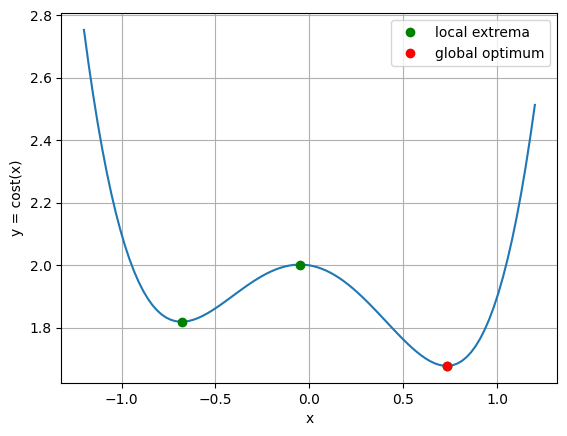

In [64]:
def cost(x):
    return x**4 - x**2 - 0.1 * x + 2


x = np.linspace(-1.2, 1.2, 100)
y = cost(x)

x_extrema = np.array((-0.680639, -0.0502538, 0.730893))
y_extrema = cost(x_extrema)
x_optimum = x_extrema[np.argmin(y_extrema)]
y_optimum = cost(x_optimum)

plt.plot(x, y)
plt.plot(x_extrema, y_extrema, "go", label="local extrema")
plt.plot(x_optimum, y_optimum, "ro", label="global optimum")
plt.xlabel("x")
plt.ylabel("y = cost(x)")
plt.grid()
plt.legend()
plt.show()


#### Schritt 1: Random Walk im Lösungsraum

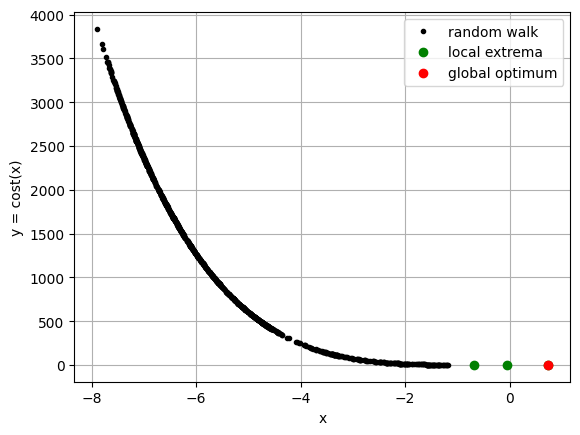

In [65]:
rng = np.random.default_rng(982374)

i = 0
xi = -1.2
yi = cost(xi)
res = [(xi, yi)]
while i < 1000:
    i += 1
    xi += rng.normal(0, 0.1)
    yi = cost(xi)
    res.append((xi, yi))

x, y = np.array(res).T

plt.plot(x, y, "k.", label="random walk")
plt.plot(x_extrema, y_extrema, "go", label="local extrema")
plt.plot(x_optimum, y_optimum, "ro", label="global optimum")
plt.xlabel("x")
plt.ylabel("y = cost(x)")
plt.grid()
plt.legend()
plt.show()


Beobachtung: Der Random Walk im Lösungsraum bewegt sich nicht in dem Bereich, wo die Funktion $f$ lokale Extrema hat. Er muss also etwas in die richtige Richtung gelenkt werden.

#### Schritt 2: Nur bessere Punkte akzeptieren

Nun werden nur diejenigen Punkte akzeptiert, die besser sind als der aktuelle Punkt. Der Random Walk bewegt sich nun in die Richtung des Minimums.

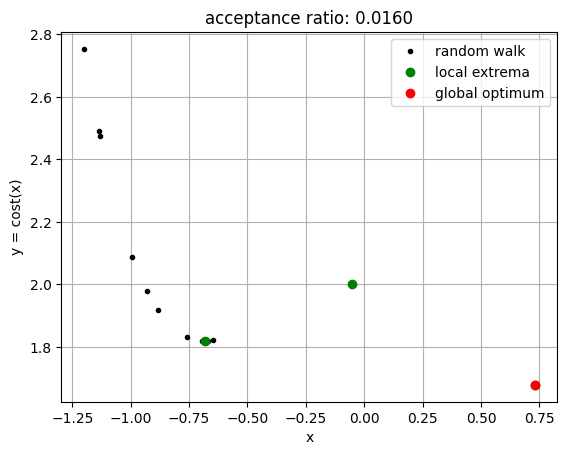

In [66]:
rng = np.random.default_rng(29834)
max_steps = 1000

i = 0
xi = -1.2
yi = cost(xi)
res = [(xi, yi)]
while i < max_steps:
    i += 1
    x_new = xi + rng.normal(0, 0.1)
    y_new = cost(x_new)
    if y_new < yi:
        xi = x_new
        yi = y_new
        res.append((xi, yi))

x, y = np.array(res).T

plt.plot(x, y, "k.", label="random walk")
plt.plot(x_extrema, y_extrema, "go", label="local extrema")
plt.plot(x_optimum, y_optimum, "ro", label="global optimum")
plt.xlabel("x")
plt.ylabel("y = cost(x)")
plt.grid()
plt.legend()
plt.title(f"acceptance ratio: {len(x) / max_steps:.4f}")
plt.show()


Beobachtung: Der Random Walk kommt nur sehr langsam vorwärts, weil zu viele Schritte nicht akzeptiert werden. Zudem besteht die Gefahr, dass der Random Walk in dem lokalen Minimum bei $x=-0.680639$ stecken bleibt.

#### Schritt 3: Akzeptanzwahrscheinlichkeit

Schliesslich soll mit einer gewissen Wahrscheinlichkeit, ein Vorschlag auch dann akzeptiert werden, wenn er eigentlich schlechter ist, als der letzte. Die Akzeptanzwahrscheinlichkeit wird mit der Temperatur $T$ gesteuert, so dass sie mit der Zeit abnimmt, damit der Algorithmus konvergiert.

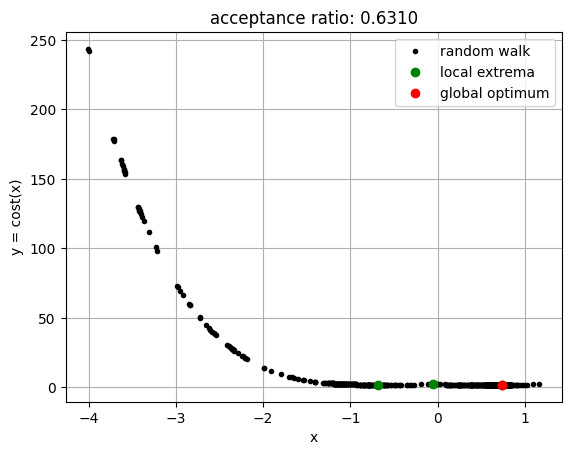

In [67]:
def acceptance_probability(new_cost, old_cost, T):
    return np.exp(-(new_cost - old_cost) / T)


def draw_neighbor(x, rng: np.random.Generator, sigma=0.1):
    return x + rng.normal(0, sigma)


rng = np.random.default_rng(12345678)
max_steps = 1000

i = 0
Ti = 10
xi = -4
yi = cost(xi)
x_best = xi
y_best = yi
res = [(xi, yi, x_best, y_best, Ti)]

while i < max_steps:
    i += 1
    Ti = Ti / 1.01
    x_new = draw_neighbor(xi, rng)
    y_new = cost(x_new)
    if y_new < yi or rng.random() < acceptance_probability(y_new, yi, Ti):
        xi = x_new
        yi = y_new
        if yi < y_best:
            x_best = xi
            y_best = yi
        res.append((xi, yi, x_best, y_best, Ti))

x, y, x_best, y_best, Ti = np.array(res).T


plt.plot(x, y, "k.", label="random walk")
plt.plot(x_extrema, y_extrema, "go", label="local extrema")
plt.plot(x_optimum, y_optimum, "ro", label="global optimum")
plt.xlabel("x")
plt.ylabel("y = cost(x)")
plt.grid()
plt.legend()
plt.title(f"acceptance ratio: {len(x) / max_steps:.4f}")
plt.show()


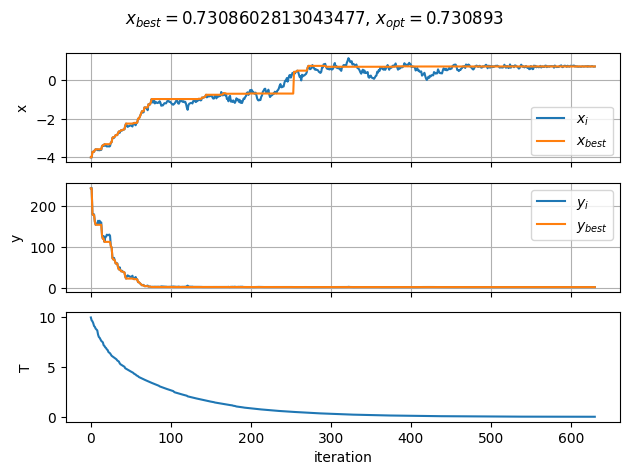

In [68]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
ax1.plot(x, label="$x_i$")
ax1.plot(x_best, label="$x_{best}$")
ax1.set_ylabel("x")
ax1.legend()
ax1.grid()
ax2.plot(y, label="$y_i$")
ax2.plot(y_best, label="$y_{best}$")
ax2.set_ylabel("y")
ax2.legend()
ax2.grid()
ax3.plot(Ti, label="T")
ax3.set_ylabel("T")
ax3.set_xlabel("iteration")
plt.suptitle(f"$x_{{best}} = {x_best[-1]}$, $x_{{opt}} = {x_optimum}$")
plt.tight_layout()
plt.show()


#### Beispiel Regression: Problemstellung

Wir haben Datenpunkte $(x_i,y_i)$ gemessen und möchten eine lineare Regression mit der Methode der kleinsten Quadrate durchführen, siehe Vertiefung Woche 2. Es gilt die [Residuenquadratsumme](https://de.wikipedia.org/wiki/Residuenquadratsumme) zu minimieren:

$$ SQR(m,b) = \sum_{i}^n \left(y_i - mx_i - b \right)^2 $$

Wir simulieren zuerst die Daten

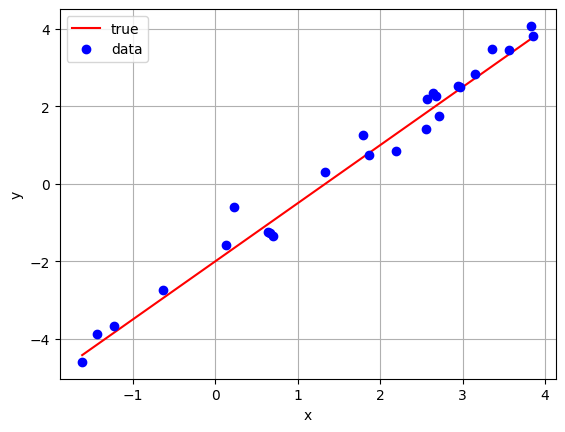

In [69]:
m_true = 1.5
b_true = -2
sigma = 0.5

rng = np.random.default_rng(42)
n = 25
x = np.sort(rng.uniform(-2, 4, size=n))
y_true = m_true * x + b_true
y = y_true + rng.normal(scale=sigma, size=n)

plt.plot(x, y_true, "r", label="true")
plt.plot(x, y, "bo", label="data")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.legend()
plt.show()


und definieren die Zielfunktion:

In [70]:
def SQR(m, b):
    return np.sum((y - (m * x + b)) ** 2)


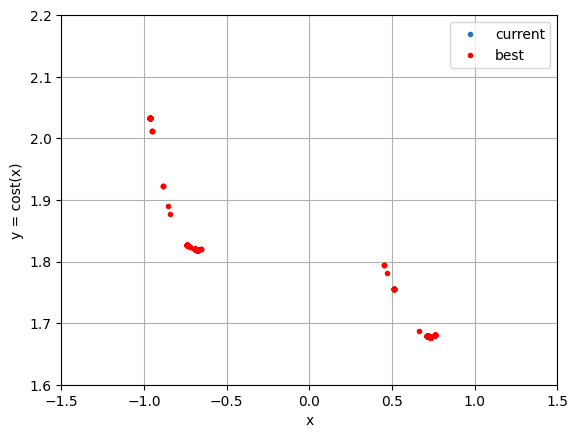

In [71]:
plt.plot(x, y, ".", label="current")
plt.plot(x_best, y_best, "r.", label="best")
plt.xlim(-1.5, 1.5)
plt.ylim(1.6, 2.2)
plt.xlabel("x")
plt.ylabel("y = cost(x)")
plt.grid()
plt.legend()
plt.show()
